In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image

from UtilFunctions import format_season

In [3]:
def pre_process(seasons, training_seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if seasons[0] > 1997 and (len(seasons) > 1 or seasons[0] > 1997+training_seasons):
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                                  'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP', 'Salary']
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        else:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP', 'Salary']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [4]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 30)},
                                 n_iter = 10, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [5]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [6]:
def train_test_split(seasons, training_seasons):
    train_df = pre_process(seasons[:-1], training_seasons)
    test_df = pre_process(seasons[-1:], training_seasons)
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], test_df.loc[:, ~test_df.columns.isin(['Pos'])], train_df['Pos'], test_df['Pos']

In [7]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [8]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [9]:
def classify_year_by_year(seasons, training_seasons=4):
    entropies_df = pd.DataFrame()
    f1_scores = pd.DataFrame()
    feature_importances = pd.DataFrame()
    confusion_matrices = {}
    accuracies = {}
    for season in seasons:
        X_train, X_test, y_train, y_test = train_test_split(range(season,season+training_seasons+1), training_seasons)
        rf = random_forest_classify(X_train, y_train)
        y_pred = rf.predict(X_test)
        labels = ["PG", "SG", "SF", "PF", "C"]
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        prob_matrix = calculate_probability_matrix(cm)
        entropies_df[season+training_seasons] = entropy_by_position(labels, prob_matrix)
        f1_scores[season+training_seasons] = f1_score(y_test, y_pred, average='micro')
        confusion_matrices[season+training_seasons] = cm
        fi = {k:v for k,v in zip(X_train.columns,rf.feature_importances_)}
        feature_importances[season] = fi
        accuracies[season+training_seasons] = accuracy_score(y_test, y_pred)
    
    return entropies_df, f1_scores, feature_importances, confusion_matrices, accuracies

In [10]:
stats_mapper = {
    'MP' : "Usage", 
    'FGA' : "Usage", 
    '3PA' : "Usage", 
    '3P%' : "Shooting", 
    '2PA' : "Usage", 
    '2P%' : "Shooting", 
    'eFG%' : "Shooting", 
    'FT%' : "Shooting", 
    'PF' : "Defensive", 
    'PTS' : "Shooting",
    'PER' : "General", 
    'TS%' : "Shooting", 
    '3PAr' : "Usage", 
    'FTr' : "Usage", 
    'ORB%' : "Rebounding", 
    'DRB%' : "Rebounding", 
    'TRB%' : "Rebounding", 
    'AST%' : "Playmaking", 
    'STL%' : "Defensive",
    'BLK%' : "Defensive", 
    'TOV%' : "Playmaking", 
    'USG%' : "Usage", 
    'OWS' : "General", 
    'DWS' : "General", 
    'WS/48' : "General", 
    'OBPM' : "General", 
    'DBPM' : "General", 
    'BPM' : "General",
}

color_mapper = {
    "Usage" : 'red',
    "Defensive": 'blue',
    "Shooting": 'green',
    "General": 'orange',
    "Rebounding" : 'purple',
    "Playmaking": 'darkgoldenrod',
}

# 4 training seasons

In [11]:
entropies_df, scores, feature_importances, confusion_matrices, accuracies = classify_year_by_year(range(1980, 2021))

## Now let's find whether each combination fits the threshold for positionless

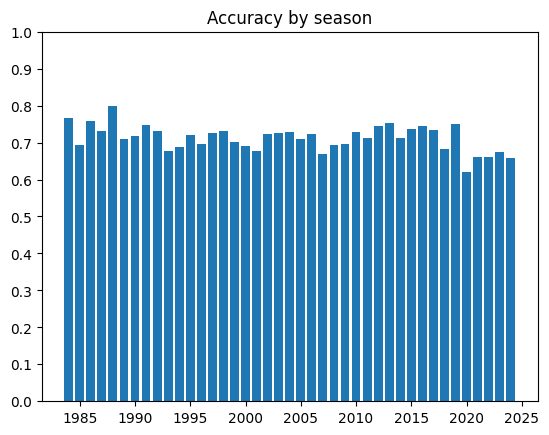

In [12]:
plt.bar(accuracies.keys(), accuracies.values())
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Accuracy by season')
plt.savefig('PositionlessArticle/ModelAccuracyBySeason.png')
plt.show()

In [49]:
print(np.mean(list(accuracies.values())))
print(np.mean(list(accuracies.values())[:21]))
print(np.mean(list(accuracies.values())[21:]))
print(np.std(list(accuracies.values())))

print(np.mean(list(accuracies.values())[11:27]))

0.7121605440589113
0.720963905183907
0.7029170148776659
0.034257327462811175
0.7087095079562701


In [14]:
feature_importances_T = feature_importances.transpose()
mean_importances = feature_importances_T.mean()
mean_importances = mean_importances.sort_values(ascending=False)
filtered_indexes = mean_importances[mean_importances > 0.018].index.tolist()
print(filtered_indexes)

['TRB%', 'AST%', 'DRB%', 'ORB%', 'BLK%', '3PAr', '3PA', 'TOV%', 'STL%', 'PF', 'DBPM', 'FGA', '3P%', 'FTr', '2PA', 'PTS', 'FT%']


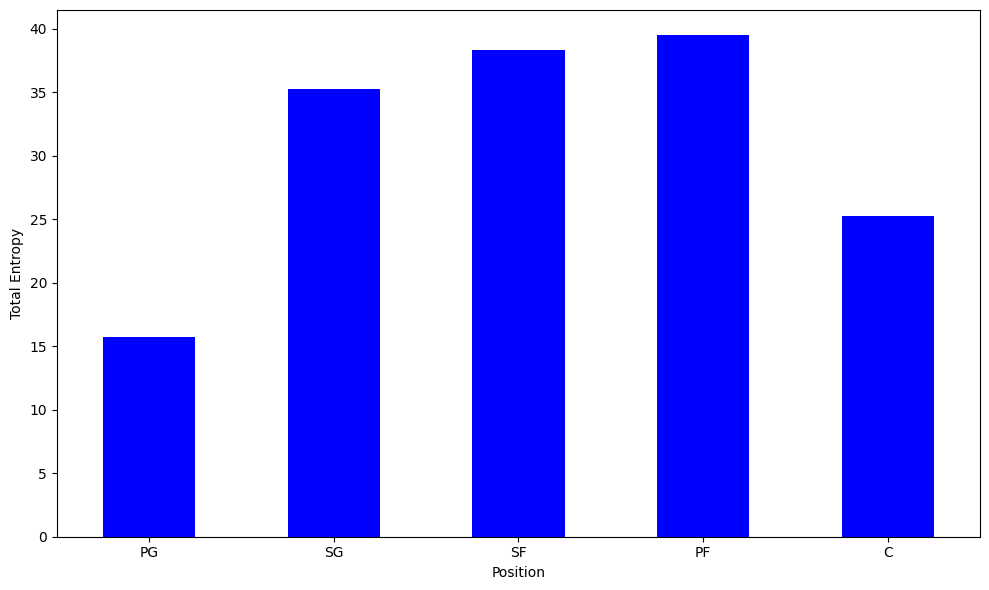

In [52]:
total_entropy_by_position = entropies_df.sum(axis=1)

# Plot the total accumulated entropy for each position
plt.figure(figsize=(10, 6))
total_entropy_by_position.plot(kind='bar', color='blue')

plt.xlabel('Position')
plt.ylabel('Total Entropy')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('PositionlessArticle/AccumulatedEntropyByPosition.png', bbox_inches='tight')
plt.show()

In [55]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

plt.xlabel('Season')
plt.ylabel('Total Entropy')
plt.xticks(rotation=20)
plt.legend(title='Position', loc='upper left', fontsize=20, title_fontsize=22)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.savefig('PositionlessArticle/AccumulatedEntropyBySeason.png', bbox_inches='tight')
plt.show()
# WILL BE USED IN THE ARTICLE

In [17]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3, prop={'size': 15})

plt.show()
#GROUP BY CATEGORY AND 5-YEAR INTERVALS. ALSO TURN INTO A LINE CHART

## Run NullHypothesis notebook to find positionless borderlines

In [23]:
import nbformat
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [38]:
with open("NullHypothesisClassifier__.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Create an interactive shell
shell = InteractiveShell.instance()

# Execute each cell in the notebook
for cell in notebook.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Entropy for PG in 1980: [np.float64(2.2918553805361017), np.float64(2.299125513429187), np.float64(2.2958320452319425), np.float64(2.1741970487449285), np.float64(2.299125513429187), np.float64(2.2566140455780976), np.float64(2.299125513429187), np.float64(2.224378359248115), np.float64(2.2958320452319425), np.float64(2.258033129867203), np.float64(2.268827273420006), np.float64(2.0765923183830246), np.float64(2.2889695442403), np.float64(2.19797732165795), np.float64(2.258033129867203), np.float64(2.2351375280701355), np.float64(2.1605418159526213), np.float64(2.2566037752408605), np.float64(2.2991255134291864), np.float64(2.2566037752408605), np.float64(2.2684954001884967), np.float64(2.2353398965201063), np.float64(2.1197575559299717), np.float64(2.2147509823331695), np.float64(2.231464380363024), np.float64(2.2795096473751655), np.float64(2.28296

In [39]:
transposed_entropies = entropies_df.transpose()
positionless_markers = {}

for i, row in transposed_entropies.iterrows():
    positionless_markers[i] = {}
    for position in POSITIONS:
        if row[position] > positionless_borderlines[i][position][1]:
            positionless_markers[i][position] = True
        else:
            positionless_markers[i][position] = False

    

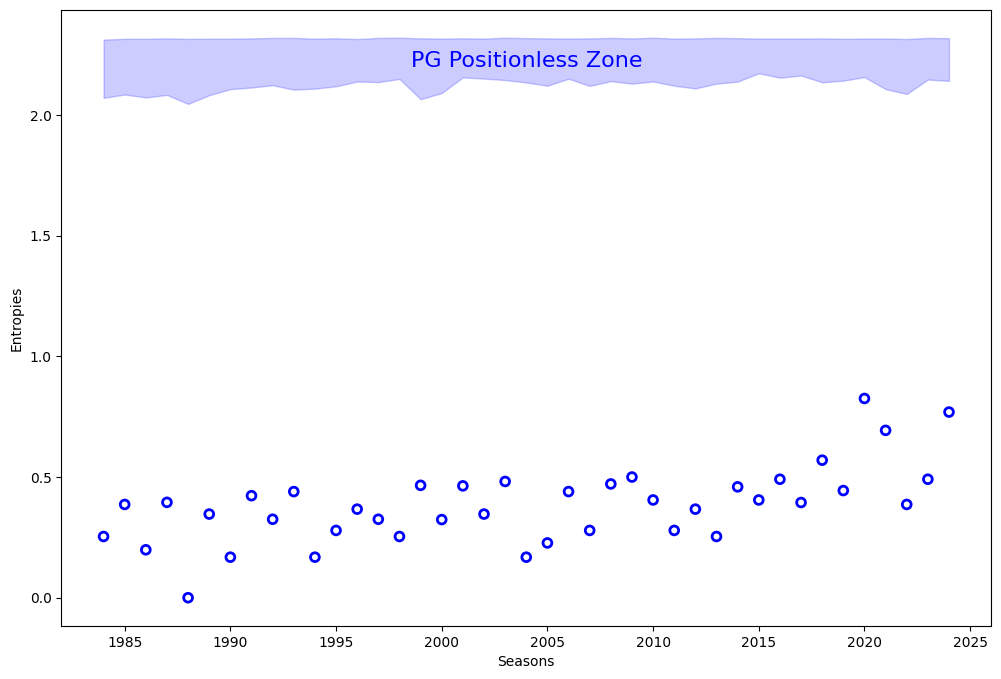

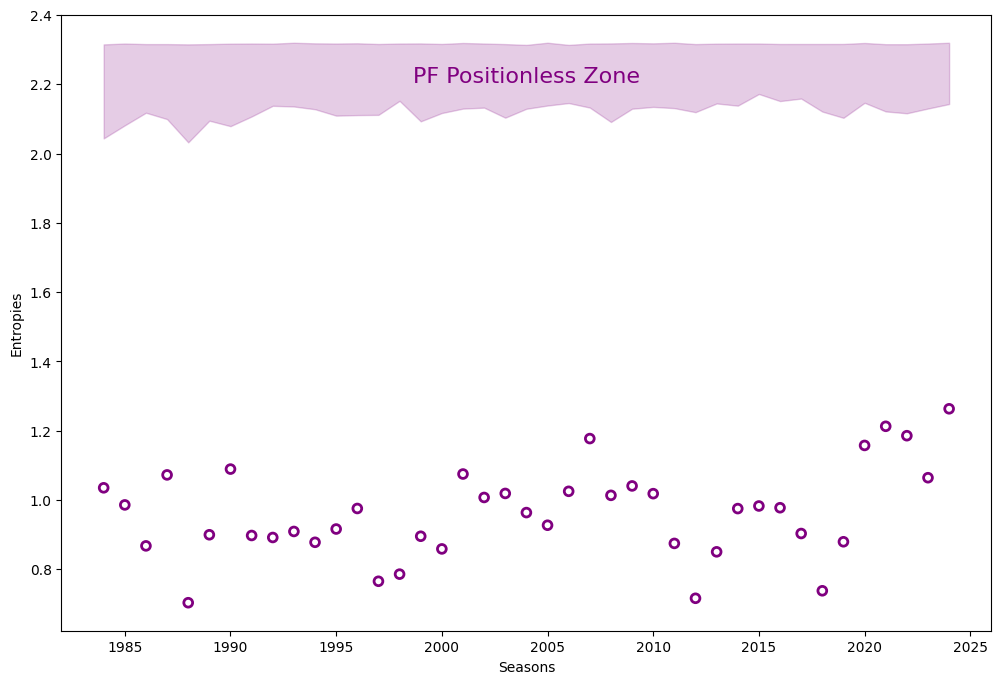

In [48]:
seasons = transposed_entropies.index
positions = transposed_entropies.columns
colors = {'PG': 'b', 'SG': 'orange', 'SF': 'g', 'PF': 'purple', 'C': 'r'}

for position in positions:
    # Create a new figure for each position
    plt.figure(figsize=(12, 8))

    # Plot the entropy scatter points for the current position
    for season in seasons:
        entropy = transposed_entropies.loc[season, position]
        fill_style = 'full' if positionless_markers[season][position] else 'none'
        
        plt.scatter(season, entropy, label=position, edgecolor=colors[position], facecolor=colors[position] if fill_style == 'full' else 'none', marker='o', s=40, lw=2)

    # Define the upper and lower bounds for the shaded area
    y_lower = [positionless_borderlines[season][position][1] for season in seasons]
    y_upper = [positionless_borderlines[season][position][3] for season in seasons]

    # Create the shaded area
    plt.fill_between(seasons, y_lower, y_upper, color=colors[position], alpha=0.2)

    # Add text inside the shaded area
    text_y_position = (np.array(y_lower) + np.array(y_upper)) / 2
    plt.text(seasons[len(seasons)//2], text_y_position[len(seasons)//2], f'{position} Positionless Zone', 
             ha='center', va='center', fontsize=16, color=colors[position], alpha=1)



    # Customize the plot
    plt.xlabel('Seasons')
    plt.ylabel('Entropies')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))

    plt.savefig(f'PositionlessArticle/EntropyThreshold_{position}.png', bbox_inches='tight')
    plt.show()